In [41]:
"""
Seoul Bike Sharing Data Preparation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [42]:
def load_data(filepath='SeoulBikeData.csv'):
    """
    Load the Seoul bike sharing dataset with error handling
    """
    
    try:
        # Try different encodings
        try:
            df = pd.read_csv(filepath)
        except:
            df = pd.read_csv(filepath, encoding='unicode_escape')
    except FileNotFoundError:
        print(f"File '{filepath}' not found")
        print(f"   Make sure the file is in the same directory as this script")
        print(f"   Current working directory: {os.getcwd()}")
        return None
    except Exception as e:
        print(f"ERROR loading file: {e}")
        return None
    
    print(f"Dataset loaded successfully")
    print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    return df

In [43]:
def clean_column_names(df):
    """
    Standardize column names
    """

    
    print(f"\nOriginal column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Create clean column names
    # Remove special characters and spaces
    column_mapping = {
        'Date': 'Date',
        'Rented Bike Count': 'Rented_Bike_Count',
        'Hour': 'Hour',
        'Temperature(°C)': 'Temperature',
        'Temperature(Â°C)': 'Temperature', 
        'Humidity(%)': 'Humidity',
        'Wind speed (m/s)': 'Wind_speed',
        'Visibility (10m)': 'Visibility',
        'Dew point temperature(°C)': 'Dew_point_temperature',
        'Dew point temperature(Â°C)': 'Dew_point_temperature',
        'Solar Radiation (MJ/m2)': 'Solar_Radiation',
        'Rainfall(mm)': 'Rainfall',
        'Snowfall (cm)': 'Snowfall',
        'Seasons': 'Seasons',
        'Holiday': 'Holiday',
        'Functioning Day': 'Functioning_Day'
    }
    
    # Apply mapping
    df_clean = df.copy()
    for old_name, new_name in column_mapping.items():
        if old_name in df_clean.columns:
            df_clean.rename(columns={old_name: new_name}, inplace=True)
    
    print(f"Cleaned column names:")
    for i, col in enumerate(df_clean.columns, 1):
        print(f"  {i:2d}. {col}")
    
    return df_clean


In [44]:
def check_data_quality(df):
    """
    Data quality checks
    """
    # Missing values
    print("\nMISSING VALUES:")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("  No missing values found!")
    else:
        print("   Missing values detected:")
        for col, count in missing[missing > 0].items():
            pct = (count / len(df)) * 100
            print(f"     {col}: {count} ({pct:.2f}%)")
    
    # Data types
    print("\nDATA TYPES:")
    print(df.dtypes)
    
    # Duplicates
    print("\nDUPLICATE ROWS:")
    n_duplicates = df.duplicated().sum()
    if n_duplicates == 0:
        print("   No duplicate rows found!")
    else:
        print(f"   Found {n_duplicates} duplicate rows")
    
    # Date range
    print("\nDATE RANGE:")
    if 'Date' in df.columns:
        # Try to parse dates
        try:
            df['Date_parsed'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
            print(f"   Start date: {df['Date_parsed'].min()}")
            print(f"   End date:   {df['Date_parsed'].max()}")
            print(f"   Duration:   {(df['Date_parsed'].max() - df['Date_parsed'].min()).days} days")
            df = df.drop('Date_parsed', axis=1)
        except:
            print("   Could not parse dates")
    
    # Check 5: Basic statistics
    print("\nBASIC STATISTICS:")
    print(df.describe())
    
    # Categorical variables
    print("\nCATEGORICAL VARIABLES:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col != 'Date':
            print(f"\n   {col}:")
            print(df[col].value_counts())
    
    # Outliers (using IQR method)
    print("\nOUTLIER DETECTION (IQR):")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_pct = (outliers / len(df)) * 100
        print(f"   {col:25s}: {outliers:4d} outliers ({outlier_pct:5.2f}%)")
    
    return df

In [45]:
def visualize_data(df):
    """
    Create visualizations of data
    """
    
    # Target variable distribution
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram
    axes[0, 0].hist(df['Rented_Bike_Count'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df['Rented_Bike_Count'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {df["Rented_Bike_Count"].mean():.0f}')
    axes[0, 0].axvline(df['Rented_Bike_Count'].median(), color='green', 
                       linestyle='--', linewidth=2, label=f'Median: {df["Rented_Bike_Count"].median():.0f}')
    axes[0, 0].set_xlabel('Rented Bike Count')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Bike Rentals')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Box plot
    axes[0, 1].boxplot(df['Rented_Bike_Count'], vert=True)
    axes[0, 1].set_ylabel('Rented Bike Count')
    axes[0, 1].set_title('Box Plot of Bike Rentals')
    axes[0, 1].grid(alpha=0.3)
    
    # Q-Q plot for normality
    from scipy import stats
    stats.probplot(df['Rented_Bike_Count'], dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot (Normality Check)')
    axes[1, 0].grid(alpha=0.3)
    
    # Cumulative distribution
    sorted_data = np.sort(df['Rented_Bike_Count'])
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    axes[1, 1].plot(sorted_data, cumulative, linewidth=2)
    axes[1, 1].axhline(0.75, color='r', linestyle='--', label='75th percentile')
    axes[1, 1].axvline(df['Rented_Bike_Count'].quantile(0.75), color='r', linestyle='--')
    axes[1, 1].set_xlabel('Rented Bike Count')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('raw_data_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Correlation heatmap
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix - Raw Data', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print correlation insights
    print("\nCORRELATION INSIGHTS:")
    
    # Find highly correlated features (|r| > 0.7)
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    
    if high_corr:
        print("   High correlations (|r| > 0.7):")
        for item in high_corr:
            print(f"     {item['Feature 1']:30s} <-> {item['Feature 2']:30s}: {item['Correlation']:6.3f}")
    else:
        print("   No high correlations found")
    
    # Correlation with target
    print("\n   Correlation with Rented_Bike_Count:")
    target_corr = correlation_matrix['Rented_Bike_Count'].sort_values(ascending=False)
    for feature, corr in target_corr.items():
        if feature != 'Rented_Bike_Count':
            print(f"     {feature:30s}: {corr:6.3f}")

In [46]:
def create_binary_target(df, percentile=75):
    """
    Create binary classification target based on percentile
    """
    
    # Calculate threshold
    threshold = np.percentile(df['Rented_Bike_Count'], percentile)
    
    # Create binary target
    df['High_Demand'] = (df['Rented_Bike_Count'] > threshold).astype(int)
    
    print(f"\nBinary target created using {percentile}th percentile")
    print(f"  Threshold: {threshold:.2f} bikes")
    print(f"\n  Class distribution:")
    print(f"    Low Demand  (0): {(df['High_Demand']==0).sum():5d} ({(df['High_Demand']==0).sum()/len(df)*100:5.2f}%)")
    print(f"    High Demand (1): {(df['High_Demand']==1).sum():5d} ({(df['High_Demand']==1).sum()/len(df)*100:5.2f}%)")
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot
    class_counts = df['High_Demand'].value_counts().sort_index()
    axes[0].bar([0, 1], class_counts.values, color=['steelblue', 'coral'], 
                edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Demand Level')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Binary Target Distribution')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['Low Demand (0)', 'High Demand (1)'])
    for i, v in enumerate(class_counts.values):
        axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Distribution comparison
    df[df['High_Demand']==0]['Rented_Bike_Count'].hist(bins=50, alpha=0.6, label='Low Demand', ax=axes[1], color='steelblue')
    df[df['High_Demand']==1]['Rented_Bike_Count'].hist(bins=50, alpha=0.6, label='High Demand', ax=axes[1], color='coral')
    axes[1].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.0f}')
    axes[1].set_xlabel('Rented Bike Count')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Rental Distribution by Class')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('03_binary_target_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df, threshold

In [47]:
def create_temporal_features(df):
    """
    Create time-based features
    """
    
    # Parse dates
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
    
    # Sort by date and hour to ensure proper temporal ordering
    df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
    
    # Day of week
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Month
    df['month'] = df['Date'].dt.month
    
    # Cyclical encoding for hour (to capture circular nature of time)
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    
    return df

In [48]:
def create_lag_features(df, lag_periods=[1]):
    """
    Create lag features (previous time periods)
    """
    
    for lag in lag_periods:
        df[f'lag_{lag}h'] = df['Rented_Bike_Count'].shift(lag)
    
    return df

In [49]:
def create_rolling_features(df, windows=[3, 24]):
    """
    Create rolling window statistics
    """
    
    for window in windows:
        # Rolling mean
        df[f'rolling_mean_{window}h'] = df['Rented_Bike_Count'].rolling(window=window, min_periods=1).mean()
        
        # Rolling std (volatility)
        df[f'rolling_std_{window}h'] = df['Rented_Bike_Count'].rolling(window=window, min_periods=1).std()
        
        # Rolling max
        df[f'rolling_max_{window}h'] = df['Rented_Bike_Count'].rolling(window=window, min_periods=1).max()
    
    return df

In [50]:
def create_interaction_features(df):
    """
    Create interaction terms between features
    """
    
    # Temperature × Hour (temp effect varies by time of day)
    df['temp_hour'] = df['Temperature'] * df['Hour']
    
    # Temperature squared (non-linear temperature effect)
    df['temp_squared'] = df['Temperature'] ** 2
    
    # Humidity × Temperature (humidity effect depends on temp)
    df['humidity_temp'] = df['Humidity'] * df['Temperature']
    
    # Wind × Rainfall (worse weather indicator)
    df['wind_rain'] = df['Wind_speed'] * df['Rainfall']
    
    return df

In [51]:
def create_all_features(df):
    """
    Create all engineered features
    """
    df = create_temporal_features(df)
    df = create_lag_features(df, lag_periods=[1, 2, 24])
    df = create_rolling_features(df, windows=[3, 6, 24])
    df = create_interaction_features(df)
    
    # Drop rows with NaN from lag/rolling features
    n_before = len(df)
    df = df.dropna().reset_index(drop=True)
    n_after = len(df)
    n_dropped = n_before - n_after
    
    return df

In [52]:
def handle_multicollinearity(df):
    """
    Identify and handle highly correlated features
    """
    
    # Calculate correlation matrix for numeric features
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['High_Demand', 'Rented_Bike_Count']]
    
    corr_matrix = df[numeric_cols].corr()
    
    # Find pairs with high correlation (> 0.9)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.9:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                
                # Calculate correlation with target
                corr1 = df[[col1, 'Rented_Bike_Count']].corr().iloc[0, 1]
                corr2 = df[[col2, 'Rented_Bike_Count']].corr().iloc[0, 1]
                
                high_corr_pairs.append({
                    'Feature 1': col1,
                    'Feature 2': col2,
                    'Correlation': corr_matrix.iloc[i, j],
                    'Target Corr 1': corr1,
                    'Target Corr 2': corr2
                })
    
    if high_corr_pairs:
        print("\nHigh multicollinearity detected (|r| > 0.9):")
        features_to_drop = []
        
        for pair in high_corr_pairs:
            print(f"\n  {pair['Feature 1']} <-> {pair['Feature 2']}")
            print(f"    Correlation: {pair['Correlation']:.3f}")
            print(f"    {pair['Feature 1']} target corr: {pair['Target Corr 1']:.3f}")
            print(f"    {pair['Feature 2']} target corr: {pair['Target Corr 2']:.3f}")
            
            # Keep the feature with higher target correlation
            if abs(pair['Target Corr 1']) < abs(pair['Target Corr 2']):
                to_drop = pair['Feature 1']
            else:
                to_drop = pair['Feature 2']
            
            if to_drop not in features_to_drop:
                features_to_drop.append(to_drop)
                print(f"    Will drop: {to_drop}")
        
        print(f"\nDropping {len(features_to_drop)} features due to multicollinearity:")
        for feature in features_to_drop:
            print(f"    - {feature}")
            df = df.drop(feature, axis=1)
    else:
        print("\nNo severe multicollinearity detected")
    
    return df

In [53]:
def prepare_final_features(df):
    """
    Prepare final X and y for modeling
    """
    
    # Define columns to drop
    drop_cols = [
        'Date',                    # Already extracted temporal features
        'Rented_Bike_Count',      # What will be predicted
        'High_Demand',            # Target
        'day_of_week',            # Encoded in is_weekend
        'month'                    # Encoded in Seasons
    ]
    
    # Drop Dew_point_temperature if it exists (multicollinear with Temperature)
    if 'Dew_point_temperature' in df.columns:
        drop_cols.append('Dew_point_temperature')
        print("   Dropping Dew_point_temperature (multicollinear with Temperature)")
    
    # Remove columns that don't exist
    drop_cols = [col for col in drop_cols if col in df.columns]
    
    # Create feature matrix
    feature_cols = [col for col in df.columns if col not in drop_cols]
    X = df[feature_cols].copy()
    y = df['High_Demand'].copy()
    
    print(f"\nPreprocessd Data Feature Matrix:")
    print(f"   Shape: {X.shape}")
    print(f"   Features ({X.shape[1]}):")
    
    # Categorize features
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\n   Numeric features ({len(numeric_features)}):")
    for feat in numeric_features:
        print(f"     - {feat}")
    
    if categorical_features:
        print(f"\n   Categorical features ({len(categorical_features)}):")
        for feat in categorical_features:
            print(f"     - {feat}")
    
    print(f"\nTarget Variable:")
    print(f"   Shape: {y.shape}")
    print(f"   Distribution: {y.value_counts().to_dict()}")
    
    return X, y, df

In [54]:
def encode_categorical_features(X):
    """
    One-hot encode categorical variables
    """
    
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    if categorical_cols:
        print(f"\nCategorical features to encode: {categorical_cols}")
        
        X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
        
        new_cols = [col for col in X_encoded.columns if col not in X.columns]
        print(f"\nCreated {len(new_cols)} dummy variables:")
        for col in new_cols:
            print(f"   - {col}")
        
        print(f"\nFinal feature matrix shape: {X_encoded.shape}")
        
        return X_encoded
    else:
        print("\nNo categorical features to encode")
        return X

In [55]:
def save_processed_data(X, y, df):
    """
    Save processed data for modeling
    """
    
    # Save full processed dataframe
    df.to_csv('processed_data_full.csv', index=False)
    print("Saved: processed_data_full.csv")
    
    # Save feature names for later use
    with open('feature_names.txt', 'w') as f:
        for col in X.columns:
            f.write(f"{col}\n")
    print("Saved: feature_names.txt")
    
    print(f"\nAll data preparation complete")
    print(f"  Total features: {X.shape[1]}")
    print(f"  Total samples: {X.shape[0]}")

Dataset loaded successfully
  Shape: 8760 rows × 14 columns

Original column names:
   1. Date
   2. Rented Bike Count
   3. Hour
   4. Temperature(°C)
   5. Humidity(%)
   6. Wind speed (m/s)
   7. Visibility (10m)
   8. Dew point temperature(°C)
   9. Solar Radiation (MJ/m2)
  10. Rainfall(mm)
  11. Snowfall (cm)
  12. Seasons
  13. Holiday
  14. Functioning Day
Cleaned column names:
   1. Date
   2. Rented_Bike_Count
   3. Hour
   4. Temperature
   5. Humidity
   6. Wind_speed
   7. Visibility
   8. Dew_point_temperature
   9. Solar_Radiation
  10. Rainfall
  11. Snowfall
  12. Seasons
  13. Holiday
  14. Functioning_Day

MISSING VALUES:
  No missing values found!

DATA TYPES:
Date                      object
Rented_Bike_Count          int64
Hour                       int64
Temperature              float64
Humidity                   int64
Wind_speed               float64
Visibility                 int64
Dew_point_temperature    float64
Solar_Radiation          float64
Rainfall      

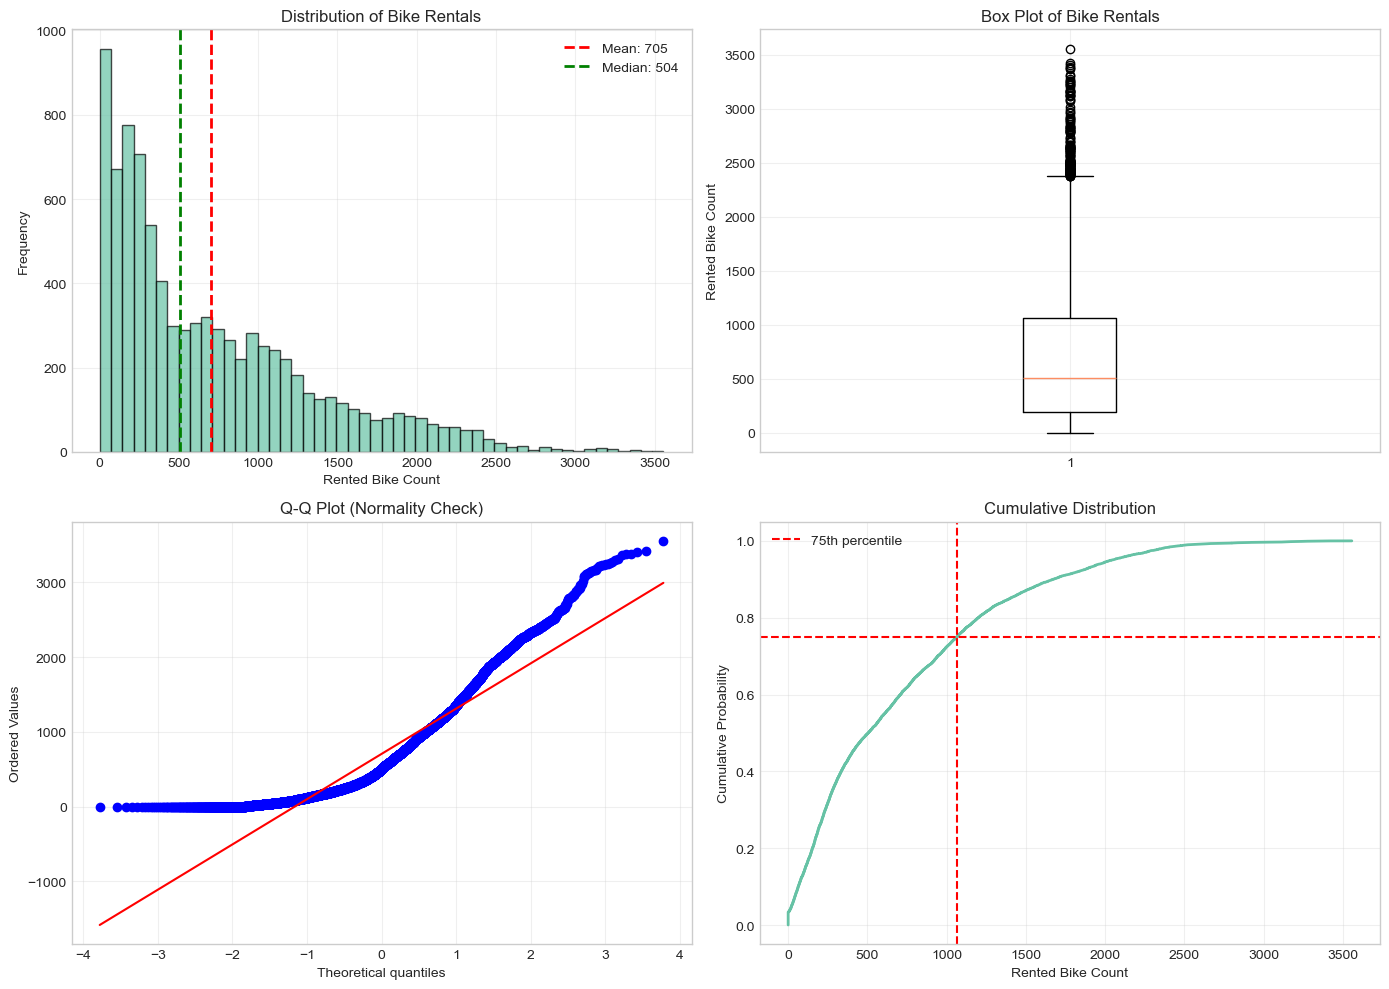

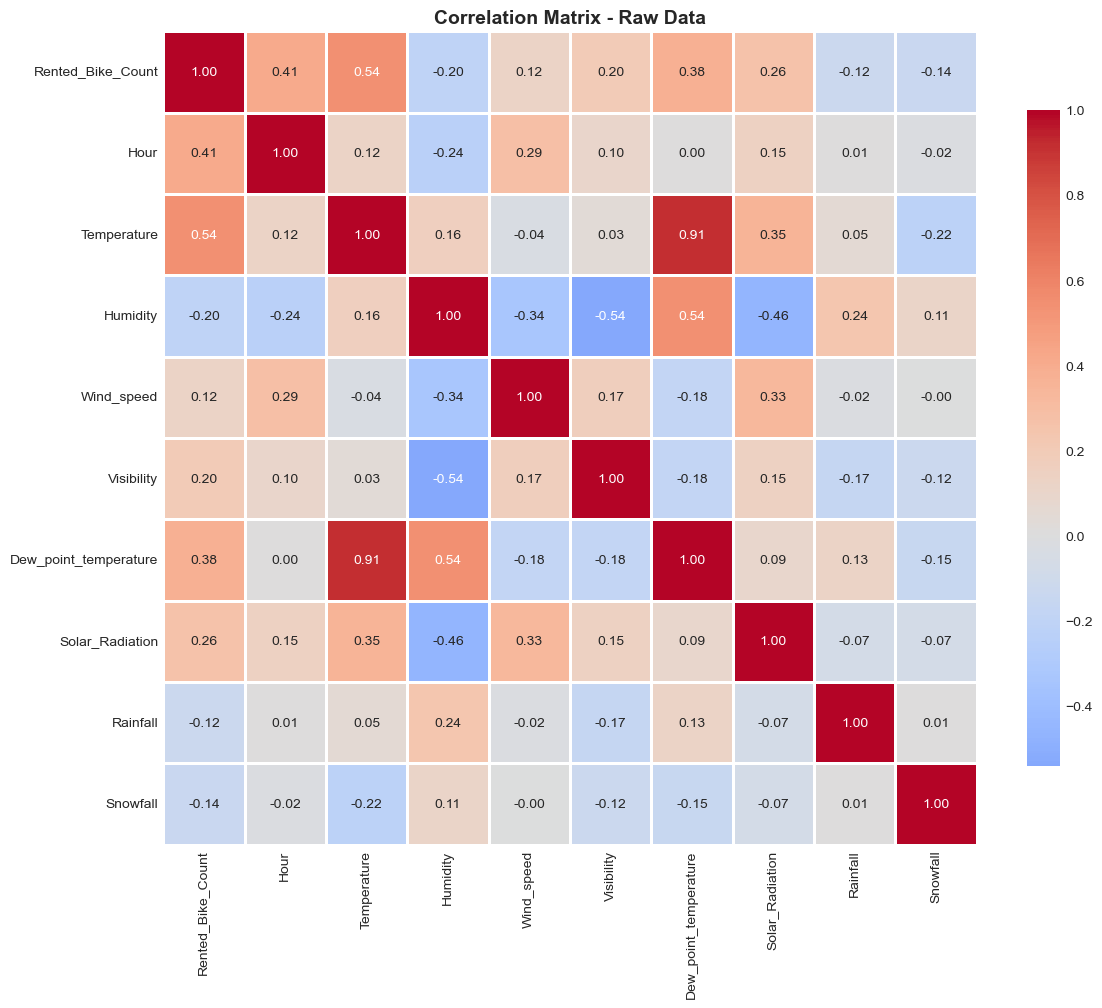


CORRELATION INSIGHTS:
   High correlations (|r| > 0.7):
     Temperature                    <-> Dew_point_temperature         :  0.913

   Correlation with Rented_Bike_Count:
     Temperature                   :  0.539
     Hour                          :  0.410
     Dew_point_temperature         :  0.380
     Solar_Radiation               :  0.262
     Visibility                    :  0.199
     Wind_speed                    :  0.121
     Rainfall                      : -0.123
     Snowfall                      : -0.142
     Humidity                      : -0.200

Binary target created using 75th percentile
  Threshold: 1065.25 bikes

  Class distribution:
    Low Demand  (0):  6570 (75.00%)
    High Demand (1):  2190 (25.00%)


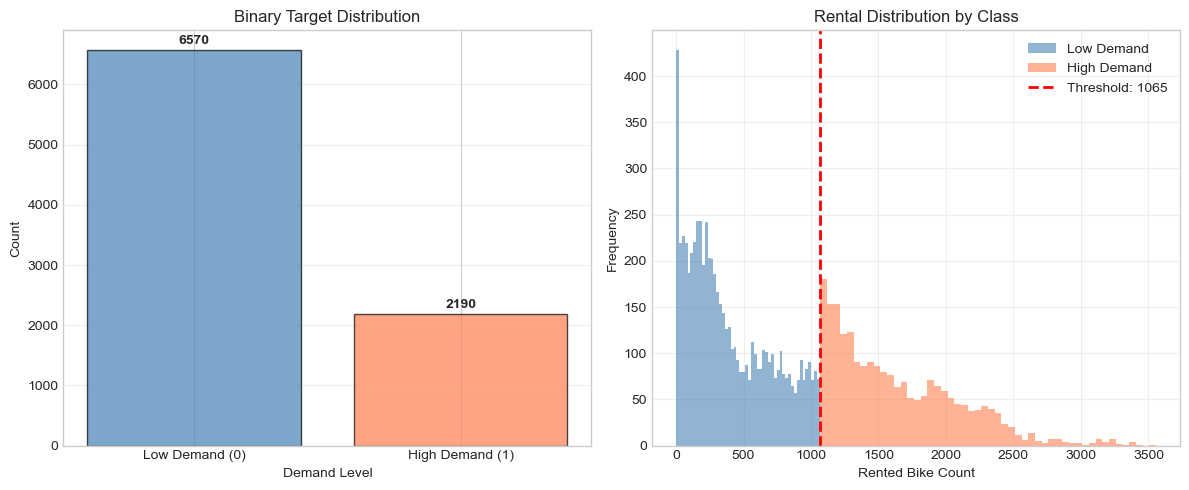


High multicollinearity detected (|r| > 0.9):

  Temperature <-> Dew_point_temperature
    Correlation: 0.913
    Temperature target corr: 0.538
    Dew_point_temperature target corr: 0.379
    Will drop: Dew_point_temperature

  Dew_point_temperature <-> humidity_temp
    Correlation: 0.958
    Dew_point_temperature target corr: 0.379
    humidity_temp target corr: 0.356
    Will drop: humidity_temp

  lag_1h <-> lag_2h
    Correlation: 0.903
    lag_1h target corr: 0.903
    lag_2h target corr: 0.764
    Will drop: lag_2h

  lag_1h <-> rolling_mean_3h
    Correlation: 0.984
    lag_1h target corr: 0.903
    rolling_mean_3h target corr: 0.935
    Will drop: lag_1h

  lag_1h <-> rolling_max_3h
    Correlation: 0.957
    lag_1h target corr: 0.903
    rolling_max_3h target corr: 0.929

  lag_2h <-> rolling_mean_3h
    Correlation: 0.935
    lag_2h target corr: 0.764
    rolling_mean_3h target corr: 0.935

  lag_2h <-> rolling_max_3h
    Correlation: 0.904
    lag_2h target corr: 0.764
  

In [56]:
def main():
    """
    Runs all data preparation steps
    """
    
    # Load data
    df = load_data('SeoulBikeData.csv')
    if df is None:
        return
    
    # Clean column names
    df = clean_column_names(df)
    
    # Data quality checks
    df = check_data_quality(df)
    
    # Visualize raw data
    visualize_data(df)
    
    # Create binary target
    df, threshold = create_binary_target(df, percentile=75)
    
    # Feature engineering
    df = create_all_features(df)
    
    # Handle multicollinearity
    df = handle_multicollinearity(df)
    
    # Prepare feature matrix
    X, y, df = prepare_final_features(df)
    
    # Encode categorical features
    X = encode_categorical_features(X)
    df_encoded = X.copy()
    df_encoded['High_Demand'] = y.values
    df_encoded['Date'] = df['Date'].values
    
    # Save processed data
    save_processed_data(X, y, df)
    
    return X, y, df, threshold

if __name__ == "__main__":
    X, y, df, threshold = main()